In [1]:
%load_ext google.cloud.bigquery 

In [2]:
!pip install google-cloud-bigquery-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.8 MB/s eta 0:00:00 0:00:01


In [3]:
!pip install pyarrow

In [58]:
%%bigquery
SELECT * 
FROM certain-arcana-418302.KK_data.ttransactions_v3
LIMIT 3

Query complete after 0.00s: 100% 2/2 [00:00<00:00, 884.41query/s]                         
Downloading: 100% 3/3 [00:00<00:00,  3.27rows/s]


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,iFbwtXr/IkqQz2GNqMqg1qbwXbAXWTiFznymvWaXBpY=,1,0,0,0,0,20150917,20150914,1
1,5QVNR1PHt40G4bxLuPrOrAdDaZo4r5lPHzS1yPivq3M=,2,195,894,894,0,20150127,20150811,0
2,6ZXfKRTXC84k0LQwZvjQfCVxprHQwG0/aDxwk5WOgEk=,3,195,894,894,0,20150703,20160113,0


In [59]:
%%bigquery
SELECT COUNT(payment_method_id) AS not_null_payment_method_id, COUNT(payment_plan_days) AS not_null_payment_plan_days,
       COUNT(plan_list_price) AS not_null_plan_list_price, COUNT(actual_amount_paid) AS not_null_actual_amount_paid,
       COUNT(is_auto_renew) AS not_null_is_auto_renew, COUNT(transaction_date) AS not_null_transaction_date,
       COUNT(membership_expire_date) AS not_null_membership_expire_date, COUNT(is_cancel) AS not_null_is_cancel
FROM certain-arcana-418302.KK_data.ttransactions_v3 

Query complete after 0.00s: 100% 2/2 [00:00<00:00, 963.43query/s]                         
Downloading: 100% 1/1 [00:01<00:00,  1.24s/rows]


,not_null_payment_method_id,not_null_payment_plan_days,not_null_plan_list_price,not_null_actual_amount_paid,not_null_is_auto_renew,not_null_transaction_date,not_null_membership_expire_date,not_null_is_cancel
0,22975416,22975416,22975416,22975416,22975416,22975416,22975416,22975416


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 

# dt as time_series operation
%matplotlib inline

# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

### 訓練集

In [5]:
from google.cloud import bigquery
import pandas as pd

# 创建 BigQuery 客户端
client = bigquery.Client()

# 执行 SQL 查询
query = """
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM certain-arcana-418302.KK_data.tuser_logs_v3
                     WHERE date > 20160901 AND date < 20170228 )
                GROUP BY msno)
SELECT train.msno, feature.user_latent_satisfaction
FROM certain-arcana-418302.KK_data.tuser_label_201703 AS train
LEFT JOIN feature
ON  train.msno = feature.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
df = query_job.to_dataframe()

# 打印结果
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      886500 non-null  object 
 1   user_latent_satisfaction  732868 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.5+ MB


In [6]:
# 执行 SQL 查询
query = """
-- day_listen CTE
WITH features AS (
                   SELECT msno AS msno , COUNT(msno) AS day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3 AS train
                   WHERE date > 20160901 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, train.is_churn, features.day_listen
FROM certain-arcana-418302.KK_data.tuser_label_201703 AS train
LEFT JOIN features 
ON   train.msno = features.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
df1 = query_job.to_dataframe()

# 打印结果
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   msno        886500 non-null  object 
 1   is_churn    886500 non-null  object 
 2   day_listen  732868 non-null  float64
dtypes: float64(1), object(2)
memory usage: 20.3+ MB


In [7]:
df_train = pd.merge(df1, df, how='left',on=['msno'])

### 測試集

In [8]:
# 执行 SQL 查询
query = """
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM certain-arcana-418302.KK_data.tuser_logs_v3
                     WHERE date > 20161001 AND date < 20170331)
                GROUP BY msno)
SELECT sub.msno, feature.user_latent_satisfaction
FROM certain-arcana-418302.KK_data.tsample_submission_v2 AS sub
LEFT JOIN feature
ON  sub.msno = feature.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dft = query_job.to_dataframe()

# 打印结果
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      907471 non-null  object 
 1   user_latent_satisfaction  749999 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.8+ MB


In [9]:
# 执行 SQL 查询
query = """
-- day_listen CTE
WITH features AS (
                   SELECT msno AS msno , COUNT(msno) AS day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3
                   -- Filter 20160201 , 20170228
                   WHERE date > 20161001 AND date < 20170331 
                   GROUP BY msno)
SELECT sub.msno, sub.is_churn, features.day_listen
FROM certain-arcana-418302.KK_data.tsample_submission_v2 AS sub
LEFT JOIN features 
ON   sub.msno = features.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dft1 = query_job.to_dataframe()

# 打印结果
dft1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   msno        907471 non-null  object 
 1   is_churn    907471 non-null  int64  
 2   day_listen  749999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ MB


In [10]:
df_sub = pd.merge(dft1, dft, how='left',on=['msno'])
df_sub.is_churn = np.nan

### tmembers_v3

In [11]:
# combine
df_train['is_churn'] = df_train['is_churn'].map({'true': 1, 'false': 0})
df_data = pd.concat([df_train, df_sub], axis=0)

In [13]:
%%bigquery
SELECT *
FROM certain-arcana-418302.KK_data.tmembers_v3
LIMIT 5

Query complete after 0.00s: 100% 1/1 [00:00<00:00, 612.66query/s] 
Downloading: 100% 5/5 [00:00<00:00,  5.79rows/s]


,msno,city,bd,gender,registered_via,registration_init_time
0,8LPzfwqAmZBC+5f6va9tf+h4Aza3swsbDx1YqqgcmGI=,14,28,female,3,20120320
1,ahZDwRrcT0nXWjhNeN30pKs4fQI4EEdQQNUbWvM1BOI=,4,30,female,3,20120320
2,y3PNyKhMefuNtFVyeRCNpPurjgNfyx4cA1rEstFjS74=,13,23,male,3,20120320
3,v5K+UvyTGjUOZaUNqiNqEpFEpv6c3GpH/8F6Iw+HVns=,13,31,male,3,20120320
4,UtZJR3a+BtwEZNwigpkB9sZDcBd3/xoJ890chDRftsU=,1,0,,7,20120320


In [12]:
# 执行 SQL 查询
query = """
SELECT *
FROM certain-arcana-418302.KK_data.tmembers_v3
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dfmem = query_job.to_dataframe()

# 打印结果
dfmem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   city                    int64 
 2   bd                      int64 
 3   gender                  object
 4   registered_via          int64 
 5   registration_init_time  int64 
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


In [13]:
df_data = pd.merge(df_data, dfmem, how='left',on=['msno'])

In [14]:
# Ordinal Encoding
gender_encode = {'male':1, 'female':2}
df_data.gender = df_data.gender.map(gender_encode)

# change feature name
df_data = df_data.rename(columns={'day_listen':'six_month_day_listen','user_latent_satisfaction':'six_month_satis'})

# missing value 
print('-'*10,'missing value summary','-'*10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_data.isnull().sum() / len(df_data))

---------- missing value summary ----------
msno                     0.000
is_churn                 0.506
six_month_day_listen     0.173
six_month_satis          0.173
city                     0.123
bd                       0.123
gender                   0.646
registered_via           0.123
registration_init_time   0.123
dtype: float64


### Registered_via

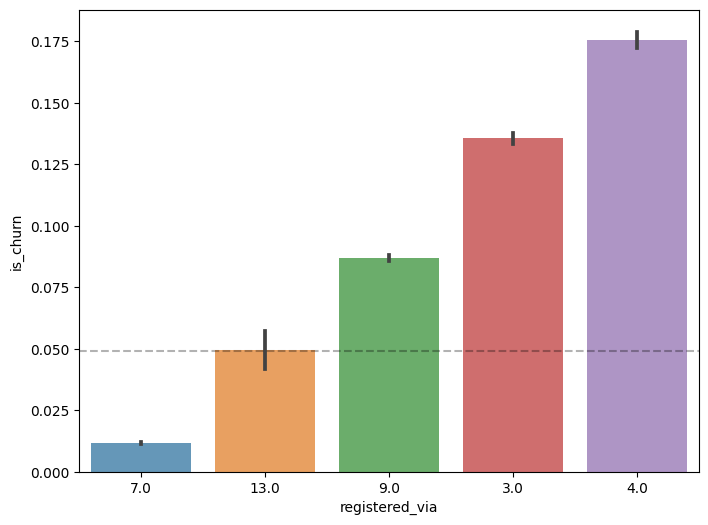

In [18]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

In [35]:
# Check null data
df_data.isna().sum()

msno                           0
is_churn                  907471
six_month_day_listen           0
six_month_satis                0
city                           0
bd                             0
gender                         0
registered_via                 0
registration_init_time         0
dtype: int64

In [15]:
columns_to_fill = ['six_month_day_listen', 'six_month_satis', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time']
df_data.loc[:, columns_to_fill] = df_data.loc[:, columns_to_fill].fillna(-1)

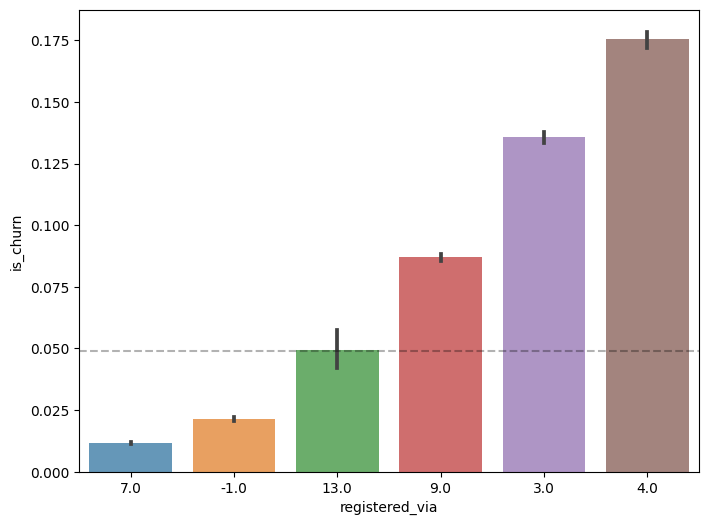

In [18]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

### Testing Model: xgb(0.165)

In [16]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [17]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [18]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')


In [40]:
df_train.isna().sum()

msno                      0
is_churn                  0
six_month_day_listen      0
six_month_satis           0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
dtype: int64

In [19]:
reg_via_fts = ['msno','is_churn','six_month_day_listen', 'six_month_satis','registered_via']
# reg_via_fts = ['msno','is_churn','six_month_day_listen','registered_via']
# training useing rf
reg_via_model, reg_via_val_score,\
reg_via_pred = model_training_rf(df_train[reg_via_fts],df_sub[reg_via_fts])
# training useing xgboost
reg_via_model_xgb, reg_via_val_score_xgb,\
reg_via_pred_xgb = model_training_xgb(df_train[reg_via_fts],df_sub[reg_via_fts])
print('rf_val_score: ',reg_via_val_score)
print('xgb_val_score: ',reg_via_val_score_xgb)

[0]	validation_0-logloss:0.23367	validation_1-logloss:0.23334
[70]	validation_0-logloss:0.16502	validation_1-logloss:0.16545
[97]	validation_0-logloss:0.16490	validation_1-logloss:0.16545
rf_val_score:  0.1686338609642456
xgb_val_score:  0.16544124157904952


### Age

年齡這個特徵在此資料集被稱為bd，筆者認為年齡在此資料集中應該含有一些資訊，例如較年輕的使用者(例如學生)普遍來說還沒有經濟能力，這可能導致他們有較高的流失率，反過來說，有經濟能力的使用者，普遍來說應該會有較低的流失率，先看看這個特徵分布的情況

In [42]:
display(df_data[['bd']].describe())
# how many % of meanful values? 
meaningful = (df_data.bd > 0 ) & (df_data.bd < 90)
print('Ages between 0 ~ 90   :  %.3f   ' %( len(df_data[meaningful]) / len(df_data) ))

,bd
count,1793971.000
mean,10.462
std,18.300
min,-3152.000
25%,0.000
50%,0.000
75%,24.000
max,2016.000


Ages between 0 ~ 90   :  0.350   


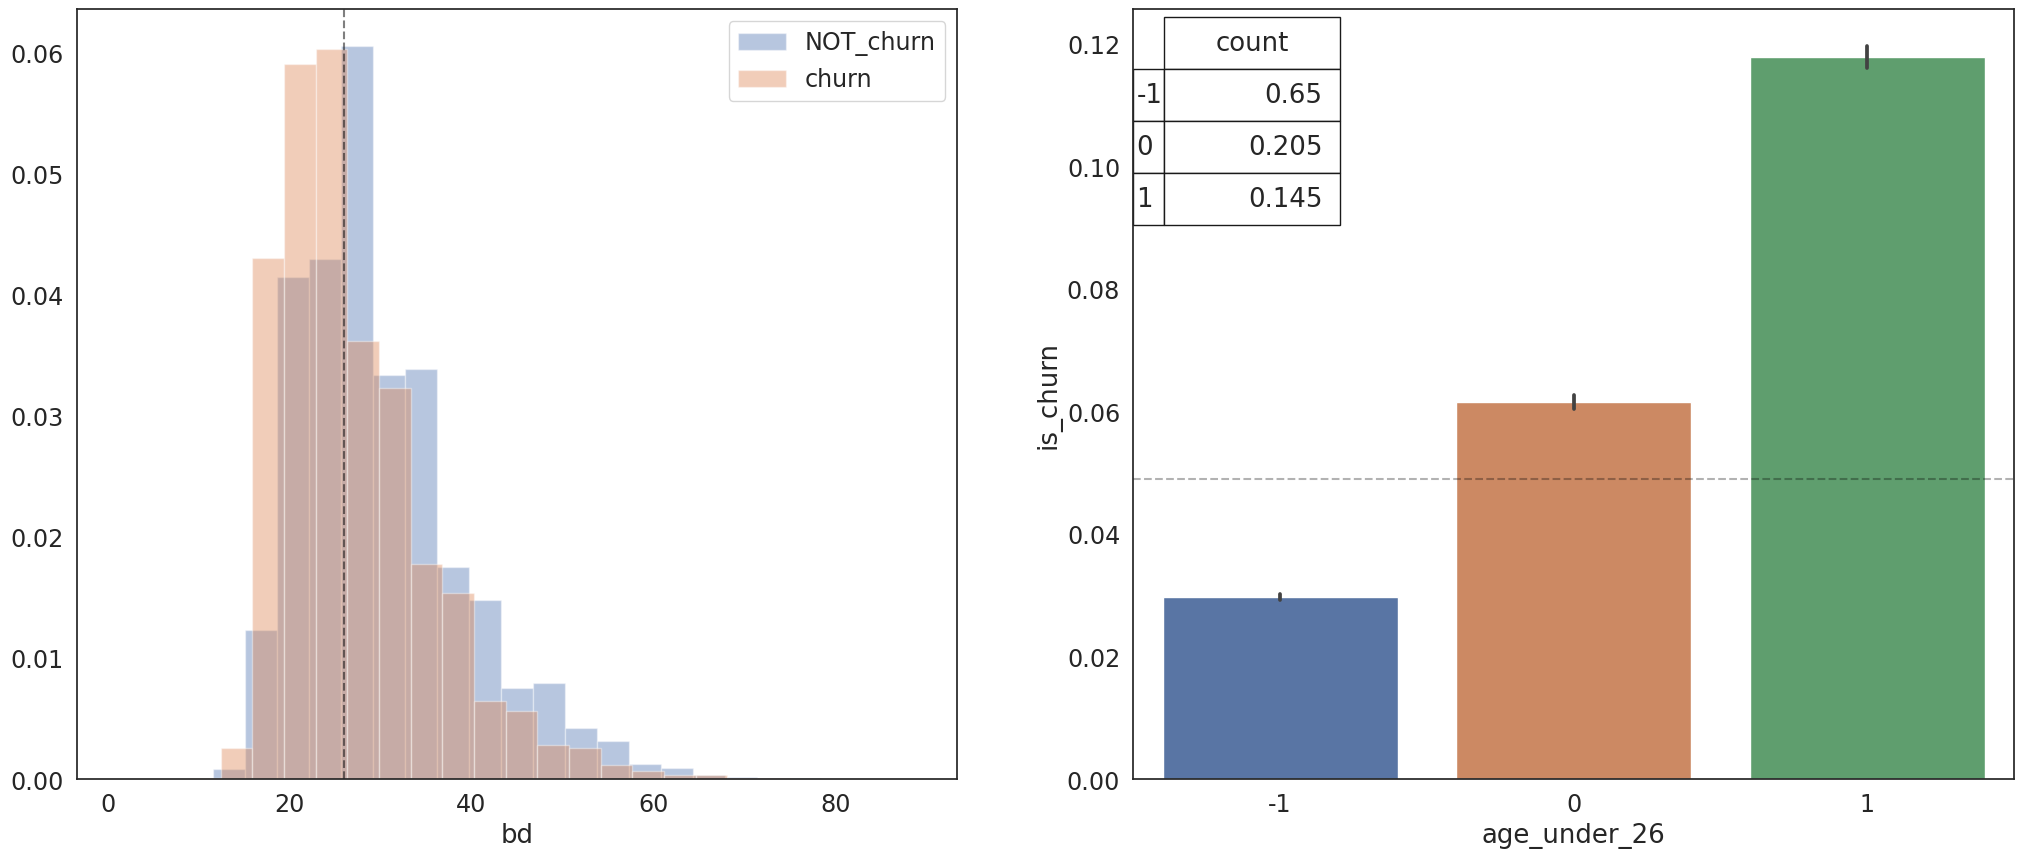

In [20]:
sns.set(font_scale=1.56)
from pandas.plotting import table

# create fig and ax 
with sns.axes_style('white'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
# distribution
    NOT_churn = ( (df_data.is_churn == 0) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    churn = ( (df_data.is_churn == 1) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    bins= 25
    sns.distplot(df_data.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_data.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# feature engineering
# create feature  bd<26 == 1, bd>26 ==0 , other = -1
    condition = df_data.bd < 26
    df_data['age_under_26'] = df_data.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_data['age_under_26'].value_counts().sort_index() / len(df_data) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_data,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

In [21]:
# split and prepare features 
df_train = df_data[:len(df_train)]
df_sub = df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
age_fts = reg_via_fts + ['age_under_26']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')


### Testing Model: xgb(0.1627)

In [22]:
print('training using features:' ,[fts for fts in age_fts if fts not in exclude_list])
age_model_xgb, age_val_score_xgb,\
age_pred_xgb = model_training_xgb(df_train[age_fts],df_sub[age_fts])
print('add_age_xgb: ', age_val_score_xgb)

training using features: ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26']
[0]	validation_0-logloss:0.23350	validation_1-logloss:0.23319
[70]	validation_0-logloss:0.16276	validation_1-logloss:0.16330
[140]	validation_0-logloss:0.16241	validation_1-logloss:0.16323
[178]	validation_0-logloss:0.16227	validation_1-logloss:0.16325
add_age_xgb:  0.16322434763641586


### Transactions table

In [60]:
%%bigquery
SELECT *
FROM certain-arcana-418302.KK_data.ttransactions
LIMIT 5

Query complete after 0.00s: 100% 2/2 [00:00<00:00, 711.99query/s]                         
Downloading: 100% 5/5 [00:00<00:00,  5.39rows/s]


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,MkgYNGcJmsoEBDbNXey0d9oUR/zAjagROi1PVVOtuM0=,35,7,0,0,0,20150528,20150615,0
1,kMITipZp6+wPnHznuOUP4v9gpjS3zSAc0/pQ3VXtPLA=,35,7,0,0,0,20150528,20150615,0
2,JukvKy8Ea4gFhTwdOfNxQfQtf3LKS4vOZw73Vwzk2iM=,35,7,0,0,0,20150528,20150615,0
3,7Ho4OMdzkXhW6U3Q9+GBJouRqEvohxYJQak2X4qBiq0=,35,7,0,0,0,20150528,20150615,0
4,0B+rduyyHPmJ6FsCFFjaCqxXx8Ioa+Ue5vv+5UPlNoQ=,35,7,0,0,0,20150528,20150615,0


In [23]:
# 执行 SQL 查询
query = """
SELECT *
FROM certain-arcana-418302.KK_data.ttransactions
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dftrans = query_job.to_dataframe()

# 打印结果
dftrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   payment_method_id       int64 
 2   payment_plan_days       int64 
 3   plan_list_price         int64 
 4   actual_amount_paid      int64 
 5   is_auto_renew           int64 
 6   transaction_date        int64 
 7   membership_expire_date  int64 
 8   is_cancel               int64 
dtypes: int64(8), object(1)
memory usage: 1.4+ GB


In [24]:
# 执行 SQL 查询
query = """
SELECT *
FROM certain-arcana-418302.KK_data.ttransactions_v2
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dftrans2 = query_job.to_dataframe()

# 打印结果
dftrans2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [25]:
# certain-arcana-418302.KK_data.ttransactions_v3: UNION DISTINCT
# df_trans_all: UNION ALL
df_trans_all = pd.concat([dftrans, dftrans2], axis = 0)
df_train_trans = pd.merge(df_train[['msno','is_churn']],df_trans_all,how='left',on=['msno'])
df_sub_trans = pd.merge(df_sub[['msno','is_churn']],df_trans_all,how='left',on=['msno'])
df_train_trans.shape, df_sub_trans.shape

((14622996, 10), (14545180, 10))

### 自定義3個壓縮資料型態的函數

轉換資料型態
1. 離散型特徵: pandas會將非數字類型的資料存成object，而越有彈性的設計相對來說就要越吃記憶體，如果確認該行列之中的重複值超過50%，我們就將其轉換成category，這會大大降低記憶體的佔用，其原理就是同樣的物體pandas將其存成一個物件，再加上不同位置的標註，這確實比起object，每一筆資料都存成一個物件，省記憶體的多
2. 數值型特徵: pandas提供了downcast的函數，如果該行的數字不需要用到很多數字，就用比較小的數字型態，例如int8支援-255到255，int16,int32,int64則是支援更多數字，也有unit及float等型態
3. 日期格式: 原本DataFrame中使用int64來表示，我們將其轉換成datetime64的格式，而考慮到效能的問題，如果使用內建函式來轉換，pandas會將數據逐一轉換，這造成了在電腦前等到天荒地老的囧境，經筆者研究之後，日期這種欄位通常重複性非常高，先在行之中取出所有單獨的日期，轉換格式之後，在map回去，就快多了

In [64]:
df_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,exX1s+1wB6wG5/EYnh6zI+CegnlCDjoEgDuSPks3ltk=,1.000,38,30,149,149,0,20150918,20151018,0
1,exX1s+1wB6wG5/EYnh6zI+CegnlCDjoEgDuSPks3ltk=,1.000,38,30,149,149,0,20160109,20160208,0
2,exX1s+1wB6wG5/EYnh6zI+CegnlCDjoEgDuSPks3ltk=,1.000,38,30,149,149,0,20160220,20160321,0
3,exX1s+1wB6wG5/EYnh6zI+CegnlCDjoEgDuSPks3ltk=,1.000,38,30,149,149,0,20160420,20160520,0
4,exX1s+1wB6wG5/EYnh6zI+CegnlCDjoEgDuSPks3ltk=,1.000,38,30,149,149,0,20151114,20151214,0


In [26]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [27]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [28]:
# rename the columns
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
df_train_trans.rename(columns=date_rename,inplace=True)
df_sub_trans.rename(columns=date_rename,inplace=True)

# converting
df_train_trans = dtype_compressor(df_train_trans)
df_sub_trans = dtype_compressor(df_sub_trans)

d = ['trans_date', 'mem_expire_date']
for col in d:
  df_train_trans[col] = fast_datetime(df_train_trans[col])
  df_sub_trans[col] = fast_datetime(df_sub_trans[col])

In [68]:
print("Traning_set missing:\n",np.around(df_train_trans.isnull().sum() / df_train_trans.shape[0],decimals=3))
print(''*60)
print("_"*60)
print(''*60)
print("Testing_set missing:\n",np.around(df_sub_trans.isnull().sum() / df_sub_trans.shape[0],decimals=3))

Traning_set missing:
 msno                 0.000
is_churn             0.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64

____________________________________________________________

Testing_set missing:
 msno                 0.000
is_churn             1.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64


In [29]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])
df_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
2044338,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-11-16,2016-12-15,0
2044335,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-12-15,2017-01-15,0
2044337,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-01-15,2017-02-15,0
2044336,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-02-15,2017-03-15,0
2044339,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-03-15,2017-04-15,0


觀察點
1. 我們將交易紀錄分別按照使用者以及日期排序，就可以看到同一個使用者的所有交易情況被放在一起，這點似乎在bigquery中辦不到，所以就使用pandas處理
2. 在這5筆交易裡，我們就可以看到一位使用者從2016-11-16一路訂閱kkbox，都是30天的約，然後一路續約到2017-04-15
3. 使用的是41號管道付費，皆為99元(讀者們可以自行觀看更多資料，就會發現，99元是訂閱一段時間過後才會有的優惠價格)
4. 續約方式都是系統自動更新，都是在即將到期時由系統自動續約

### 針對是回鍋使用者(表示曾經流失過)

是否是回鍋使用者(表示曾經流失過): 建立一個合約天數的特徵來觀察得更清楚

合約天數(membership_int) = 會員到期日(mem_expire_date) - 交易日期(trans_date)

In [30]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])

# build membership
# now vectorlized (時間差除以這個 timedelta64 物件可以得到時間差的天數)
df_train_trans['membership_int'] = (df_train_trans['mem_expire_date'] - df_train_trans['trans_date']).dt.days
df_sub_trans['membership_int'] = (df_sub_trans['mem_expire_date'] - df_sub_trans['trans_date']).dt.days

# glance 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display_side_by_side(df_train_trans[['membership_int','payment_plan_days']].describe(),\
                    df_sub_trans[['membership_int','payment_plan_days']].describe())

,membership_int,payment_plan_days
count,14622996.000,14622996.000
mean,36.552,30.071
std,85.576,18.187
min,-17217.000,0.000
25%,30.000,30.000
50%,31.000,30.000
75%,31.000,30.000
max,2796.000,450.000
,membership_int,payment_plan_days
count,14545180.000,14545180.000


依照上述，照理說合約天數(membership_int)應該要和payment_plan_days(訂閱幾天)的值是一樣的。可能的原因是資料庫的錯誤(例如日期跳回1970/1/1)，或是直接跳到2020等等

事實上現實生活中很多這種資料，根本處理不完(如果你沒有一個專門資料清理的團隊的話)，權衡之計就是評估這種資料的比例，以及他對於我們想預測的目標影響力有多大

筆者發現: 如果是曾經流失過的使用者，又回鍋使用kkbox，則之後流失的機率也會比較高，這可建構出多個特徵(例如上一次是否流失，總共流失幾次......等等)

我們可以透過原本該筆交易的合約天數，來重新修正會員到期日，原本想像的大概就是這麼簡單，但是這個資料集實在很頑強，有很多難搞的地方

### 調整到期日expire (訓練資料)，分成以下四種狀況

1. is_cancel -> 交易是否取消
2. payment_plan_days -> 原始交易天數
3. trans_date -> 交易日期 (簡稱trans)
4. mem_expire_date -> 到期日期 (簡稱expire)
5. membership_int -> 修改過的交易天數 (expire - trans)

### is_cancel = 0 && membership_int < -30 (訓練資料)

In [31]:
print("_"*15," 針對訓練資料的異常值 ", "_"*15)
print("if (is_cancel = 0 && membership_int < -30)")
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 0))
print(df_train_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
print(''*60)
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
print("if (is_cancel = 0 && membership_int < -30 && payment_plan_days = 0)")
print(df_train_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())

_______________  針對訓練資料的異常值  _______________
if (is_cancel = 0 && membership_int < -30)
payment_plan_days
0       179
30     1184
60       74
120       6
180       6
240      12
Name: count, dtype: int64

if (is_cancel = 0 && membership_int < -30 && payment_plan_days = 0)
actual_amount_paid
0        1
149    178
Name: count, dtype: int64


調整expire
1. if (is_cancel = 0 && membership_int < -30 && payment_plan_days != 0) -> expire = trans + payment_plan_days 
2. if (is_cancel = 0 && membership_int < -30 && payment_plan_days = 0) -> expire = trans + 30

In [32]:
# if (is_cancel = 0 && membership_int < -30 && payment_plan_days != 0)
#      expire = trans + payment_plan_days
con = ((df_train_trans.membership_int.between(min_date,-30)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
# df_train_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days, 'trans_date'] + \
#                                                                 df_train_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.offsets.Day()
df_train_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days, 'trans_date'] + \
                                                                df_train_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.Timedelta('1 days')

# if (is_cancel = 0 && membership_int < -30 && payment_plan_days = 0)
#      expire = trans + 30
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
# df_train_trans.loc[con & are_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & are_0_plan_days, 'trans_date'] + pd.DateOffset(days=30)
df_train_trans.loc[con & are_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & are_0_plan_days, 'trans_date'] + pd.Timedelta('30 days')

### is_cancel = 0 && membership_int > 450 (訓練資料)

In [33]:
print("_"*15," 針對訓練資料的異常值 ", "_"*15)
print("if (is_cancel = 0 && membership_int > 450)")
print(print(df_train_trans.loc[(df_train_trans['membership_int'] > 450), 'payment_plan_days'].value_counts().sort_index()))
print(''*60)
print("if (is_cancel = 0 && membership_int > 450 && payment_plan_days = 0)")
con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)
print(df_train_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())

_______________  針對訓練資料的異常值  _______________
if (is_cancel = 0 && membership_int > 450)
payment_plan_days
0       3207
1         12
10         2
14         1
30     74547
90         1
180        3
195        2
360       14
365        2
395      142
400        9
410      108
450       75
Name: count, dtype: int64
None

if (is_cancel = 0 && membership_int > 450 && payment_plan_days = 0)
actual_amount_paid
100       17
119      252
129      268
149     2657
1599      11
1788       2
Name: count, dtype: int64


調整expire
1. if (is_cancel = 0 && membership_int > 450 && payment_plan_days != 0) -> expire = trans + payment_plan_days 
2. if (is_cancel = 0 && membership_int > 450 && payment_plan_days = 0)

        if actual_amount_paid = {100,119,129,149} --> expire = trans + 30 days

        if actual_amount_paid = {1599,1788} --> expire = trans + 400 days

In [34]:
# if (is_cancel = 0 && membership_int > 450 && payment_plan_days != 0) 
#      expire = trans + payment_plan_days
max_date = df_train_trans.membership_int.max()
con = ((df_train_trans.membership_int.between(450,max_date)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
# df_train_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days, 'trans_date'] + \
#                                                                 df_train_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.offsets.Day()
df_train_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days, 'trans_date'] + \
                                                                df_train_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.Timedelta('1 days')

# if actual_amount_paid = {100,119,129,149} 
#      expire = trans + 30 days
con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)
paid_30_days = df_train_trans.actual_amount_paid.isin([100,119,129,149])
# df_train_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
# df_train_trans.loc[con & paid_30_days, 'trans_date'] + pd.DateOffset(days=30)
df_train_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# if actual_amount_paid = {1599,1788} 
#      expire = trans + 400 days
paid_400_days = df_train_trans.actual_amount_paid.isin([1599,1788])
# df_train_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
# df_train_trans.loc[con & paid_400_days, 'trans_date'] + pd.DateOffset(days=400)
df_train_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

### is_cancel = 1 && membership_int < -30 (訓練資料)

調整expire

if (is_cancel = 1 && membership_int < -30) -> expire = trans

In [35]:
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date']

### is_cancel = 1 && membership_int > 450 (訓練資料)

調整expire

if (is_cancel = 1 && membership_int > 450) -> expire = trans

In [36]:
con = ((df_train_trans.membership_int.between(450, max_date)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date']

### 調整到期日expire (測試資料)

In [37]:
# if (is_cancel = 0 && membership_int < -30 && payment_plan_days != 0)
#      expire = trans + payment_plan_days
con = ((df_sub_trans.membership_int.between(min_date,-30)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
# df_sub_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days, 'trans_date'] + \
#                                                                 df_sub_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.offsets.Day()
df_sub_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days, 'trans_date'] + \
                                                                df_sub_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.Timedelta('1 days')

# if (is_cancel = 0 && membership_int < -30 && payment_plan_days = 0)
#      expire = trans + 30
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
# df_sub_trans.loc[con & are_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & are_0_plan_days, 'trans_date'] + pd.DateOffset(days=30)
df_sub_trans.loc[con & are_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & are_0_plan_days, 'trans_date'] + pd.Timedelta('30 days')

In [38]:
# if (is_cancel = 0 && membership_int > 450 && payment_plan_days != 0) 
#      expire = trans + payment_plan_days
max_date = df_sub_trans.membership_int.max()
con = ((df_sub_trans.membership_int.between(450,max_date)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
# df_sub_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days, 'trans_date'] + \
#                                                                 df_sub_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.offsets.Day()
df_sub_trans.loc[con & not_0_plan_days, 'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days, 'trans_date'] + \
                                                                df_sub_trans.loc[con & not_0_plan_days, 'payment_plan_days'] * pd.Timedelta('1 days')

# if actual_amount_paid = {100,119,129,149} 
#      expire = trans + 30 days
con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)
paid_30_days = df_sub_trans.actual_amount_paid.isin([100,119,129,149])
# df_sub_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
# df_sub_trans.loc[con & paid_30_days, 'trans_date'] + pd.DateOffset(days=30)
df_sub_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# if actual_amount_paid = {1599,1788} 
#      expire = trans + 400 days
paid_400_days = df_sub_trans.actual_amount_paid.isin([1599])
# df_sub_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
# df_sub_trans.loc[con & paid_400_days, 'trans_date'] + pd.DateOffset(days=400)
df_sub_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

In [39]:
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date']

In [40]:
con = ((df_sub_trans.membership_int.between(450, max_date)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date']

### Data leakage problem

In [41]:
print(df_train_trans[df_train_trans.trans_date > np.datetime64('2017-03-01')].shape)
print(df_sub_trans[df_sub_trans.trans_date > np.datetime64('2017-04-01')].shape)

(853747, 11)
(0, 11)


我們訓練集中是要預測3月是否流失，因此我們不能使用3月的交易數據，否則就是數據洩漏了(Data leakage)。我們觀察到3月的交易數據共有853,747筆，這些需要丟棄，而測試集則沒有

In [42]:
df_train_trans = df_train_trans[ ~ (  df_train_trans.trans_date > np.datetime64('2017-03-01')  ) ]
df_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13769249 entries, 2044338 to 13031186
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   msno                category      
 1   is_churn            int8          
 2   payment_method_id   int8          
 3   payment_plan_days   int16         
 4   plan_list_price     int16         
 5   actual_amount_paid  int16         
 6   is_auto_renew       int8          
 7   trans_date          datetime64[ns]
 8   mem_expire_date     datetime64[ns]
 9   is_cancel           int8          
 10  membership_int      int64         
dtypes: category(1), datetime64[ns](2), int16(3), int64(1), int8(4)
memory usage: 643.1 MB


### check 非連續使用的使用者(last_last_churn = 1)

In [43]:
def ll_churn(df):

  # 首先，對數據進行排序，按照 'msno' 和 'trans_date' 欄位
  df = df.sort_values(by=['msno','trans_date'],ascending=True)

  # 即下一次交易的日期減去當前交易的會員到期日期
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']

  # 判斷每行是否屬於同一個用戶（即 'msno' 是否相同）
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)

  # 使用閾值來判斷是否存在流失情況。如果下一次交易之後的時間間隔超過30天且是同一個用戶
  # 則將 'churn_record' 標記為1（表示可能的流失），否則標記為0
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  # 將 'churn_record' 列中的布爾值轉換為數字（0或1） 
  df['churn_record'] = df['churn_record']*1
  
  # 對數據進行排序，這次是按 'msno' 和 'mem_expire_date' 欄位進行降序排序
  df = df.sort_values(by=['msno','mem_expire_date'],ascending=False)

  # 從每個用戶的最後兩次交易中選取第二次交易，並提取出其中的 'churn_record' 列作為最後一次流失的記錄
  ft = df.groupby(by=['msno'],as_index=False).nth(1)[['msno','churn_record']]
  ft = ft.rename(columns={'churn_record':'last_last_churn'})
  
  return ft

In [44]:
# get features
ft_last_last_churn_train = ll_churn(df_train_trans)
ft_last_last_churn_sub = ll_churn(df_sub_trans)

# merge
df_train = pd.merge(df_train,ft_last_last_churn_train,how='left',on=['msno']);
df_sub = pd.merge(df_sub,ft_last_last_churn_train,how='left',on=['msno']);

# only one trans_record does not have last_last_churn information
df_train.last_last_churn = df_train.last_last_churn.fillna(-1)
df_sub.last_last_churn = df_sub.last_last_churn.fillna(-1)
print('_'*30, 'traning set', '_'*30)
print(''*60)
print(df_train.last_last_churn.value_counts())
print('_'*30, 'testing set', '_'*30)
print(''*60)
print(df_sub.last_last_churn.value_counts())

______________________________ traning set ______________________________

last_last_churn
0.000     839069
-1.000     36788
1.000      10643
Name: count, dtype: int64
______________________________ testing set ______________________________

last_last_churn
0.000     785585
-1.000    117405
1.000       4481
Name: count, dtype: int64


我們可以看到非連續訂閱的使用者事實上並不多，而測試集的非連續訂閱使用者又更少，其中-1為缺失值，這裡的缺失值是我們創建特徵的過程產生的，並非原本資料庫缺失，然而在創建這個特徵時哪裡會產生缺失值呢?

沒有上一筆資料的使用者

沒有上一筆資料的使用者當然就沒有連續訂閱的紀錄，也就是說，這個特徵還碰巧定義出了新使用者(僅有一次訂閱紀錄)

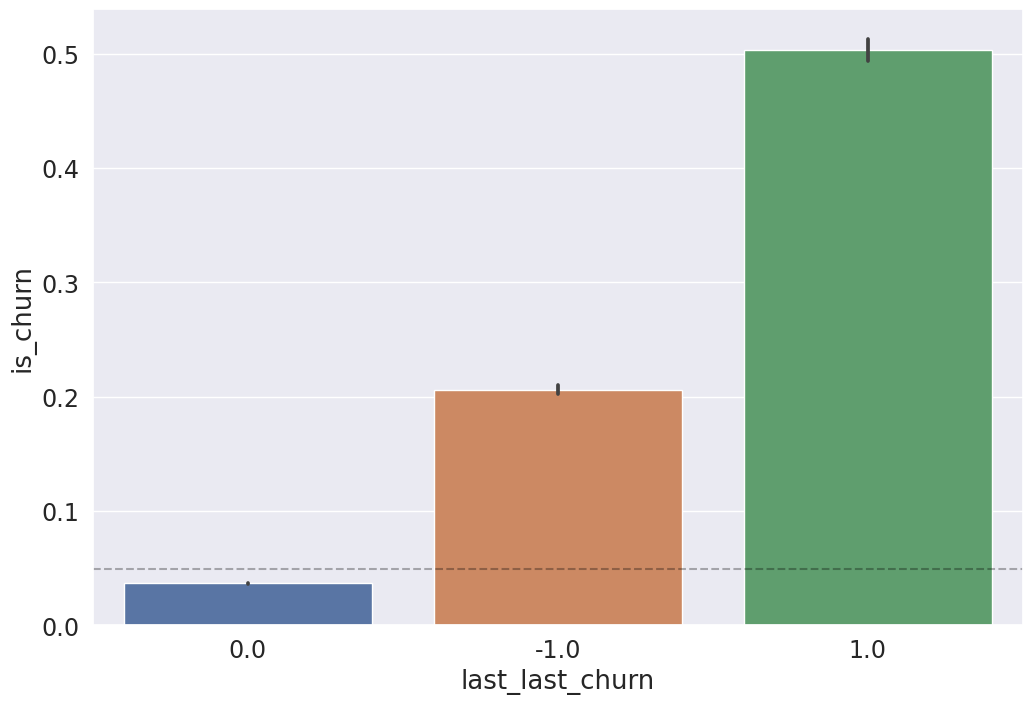

In [85]:
result_ll_churn = df_train.groupby(["last_last_churn"])['is_churn'].mean().reset_index().sort_values('is_churn')
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='last_last_churn', y='is_churn', data=df_train,ax=ax,order=result_ll_churn['last_last_churn'])
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

橫軸為last_last_churn(表示上上次是否流失，0表示為連續訂閱的使用者，-1表示為新使用者，1表示為非連續訂閱的使用者，縱軸為流失率，黑線為95%信賴區間。)

### Testing Model: xgb(0.154)

In [45]:
print(df_train.columns)
print(df_sub.columns)
ll_churn_fts = age_fts + ['last_last_churn']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')


In [46]:
print('training using features: \n' ,[fts for fts in ll_churn_fts if fts not in exclude_list])
ll_churn_model_xgb, ll_churn_val_score_xgb,\
ll_churn_pred_xgb = model_training_xgb(df_train[ll_churn_fts],df_sub[ll_churn_fts])
print(ll_churn_val_score_xgb)

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn']
[0]	validation_0-logloss:0.23212	validation_1-logloss:0.23179
[70]	validation_0-logloss:0.15439	validation_1-logloss:0.15486
[140]	validation_0-logloss:0.15393	validation_1-logloss:0.15469
[179]	validation_0-logloss:0.15379	validation_1-logloss:0.15471
0.15467780469900227


### Trans_times and client_level_code

在交易記錄的資料集中我們有每一個使用者的交易紀錄，我們可以經由交易次數大略推估使用者對這個訂閱服務的喜好程度，這有助於我們辨別持續使用者的流失情況以及分群

In [47]:
# 交易次數 -> 喜好程度
ft_trans_times_train = df_train_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
ft_trans_times_sub = df_sub_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});

In [48]:
df_train = pd.merge(df_train, ft_trans_times_train, how='left', on=['msno'])
df_sub = pd.merge(df_sub, ft_trans_times_sub,how='left', on=['msno'])

In [49]:
df_data = pd.concat([df_train, df_sub], axis=0)

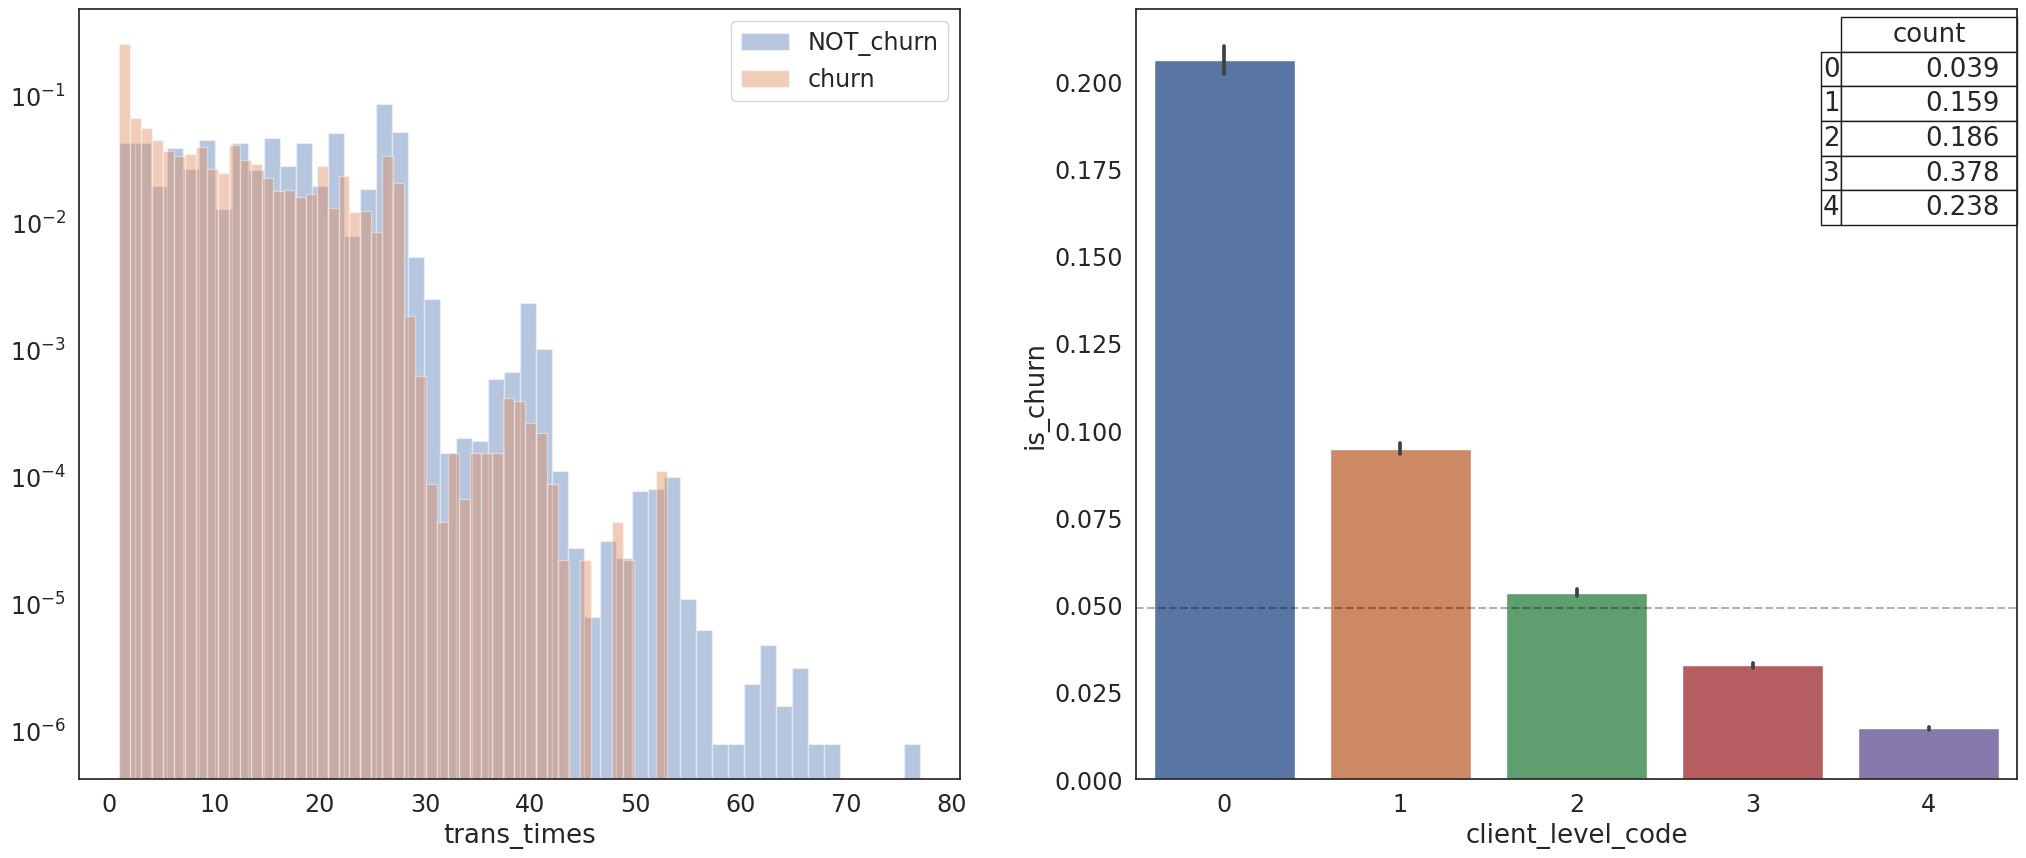

In [50]:
sns.set(font_scale=1.56)
# create fig and ax 
with sns.axes_style('white'):

  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
    
  sns.distplot(df_data.loc[(df_data.is_churn == 0), 'trans_times'],kde=False, label='NOT_churn',ax=ax1,norm_hist=True)
  sns.distplot(df_data.loc[(df_data.is_churn == 1), 'trans_times'],kde=False, label='churn',ax=ax1,norm_hist=True)
  ax1.legend()
  ax1.set_yscale('log')

  # feature enineering
  # New, Trying, OneYear, TwoYear, Stable
  max_trans = df_data.trans_times.max()
  bins = [0,1,6,12,24,max_trans]

  # period = nodes - 1 --> labels = np.arange(len( bins) -1 )
  df_data['client_level_code'] = pd.cut(df_data.trans_times, bins, labels= np.arange( len( bins) - 1 ) )
  df_data['client_level_code'] = df_data['client_level_code'].astype('int8')

  # prepare table (% of each value)
  df_percent = pd.DataFrame( df_data['client_level_code'].value_counts().sort_index() / len(df_data) ).round(3) 
  # barplot of churn rate
  sns.barplot(x='client_level_code',y='is_churn',data=df_data,ax=ax2)
  ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

按照交易紀錄次數分組，這裡取1(新使用者，1-6次，6-12次，12-24次，24次以上)，可以預期越是老顧客直覺上越不會流失

***這裡筆者隱含假設了每個交易紀錄是1個月，因此超過1個月的用這種方式分組就會顯得不適合，在此當作噪聲(noise)

我們可以看到左圖在交易次數40次以上的藍色有突出的一塊，這印證了我們的直覺，老客戶們的流失率是更低的，同時也反映在右圖的第4個類別，流失率很低，低於2.5%

右圖的類別0和上一個特徵Last_last_churn有重複解釋的部分，都表示為新使用者，也可以當作驗算，流失率為20%，接下來隨著訂閱次數的累積，使用者的流失率逐漸穩定下來，在類別3之後的流失率開始低於平均，我們亦可以依據此資料粗估，使用者在訂閱1年後，逐漸被過濾出喜歡kkbox服務的顧客

### Testing Model: xgb(0.1508)

In [51]:
# split and prepare features 
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
client_level_code_fts = ll_churn_fts + ['client_level_code']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code'],
      dtype='object')


In [52]:
print('training using features: \n' ,[fts for fts in client_level_code_fts if fts not in exclude_list])
client_level_code_model_xgb, client_level_code_val_score_xgb,\
client_level_code_pred_xgb = model_training_xgb(df_train[client_level_code_fts],df_sub[client_level_code_fts])
client_level_code_val_score_xgb

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn', 'client_level_code']
[0]	validation_0-logloss:0.23192	validation_1-logloss:0.23158
[70]	validation_0-logloss:0.15111	validation_1-logloss:0.15144
[140]	validation_0-logloss:0.15049	validation_1-logloss:0.15111
[210]	validation_0-logloss:0.15016	validation_1-logloss:0.15104
[274]	validation_0-logloss:0.14990	validation_1-logloss:0.15101


0.15100178116935312

### Last_auto_renew

是否自動更新這個特徵筆者認為某種程度顯示了使用者的經濟情況以及對商品的愛好度，畢竟一個不算充裕或是沒有很喜歡產品的使用者在發現了商品會自動延續訂閱這件事之後多半會覺得是不是想要坑消費者，進而取消自動更新

針對這個特徵我們以使用者為單位，來看看每一位使用者所有交易紀錄中，自動更新的比率:

In [53]:
# 對數據按照 'msno' 和 'mem_expire_date' 欄位進行排序，其中 'msno' 欄位降序排序，'mem_expire_date' 欄位升序排序
# 對數據進行分組，根據 'msno' 欄位，並對 'is_auto_renew' 列進行累加求和，得到每個用戶截止到目前為止的自動續訂次數，這一步使用了 groupby.cumsum() 函數
df_train_trans = df_train_trans.sort_values(by=['msno'],ascending=False).sort_values(by=['mem_expire_date'],ascending=True)
df_train_trans['auto_renew_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumsum()

# 驗證(用另一種函數) 
# 對數據按照 'msno' 和 'mem_expire_date' 欄位進行排序，其中 'msno' 和 'mem_expire_date' 欄位都降序排序
# 對數據進行分組，根據 'msno' 欄位，並對 'is_auto_renew' 列進行累加計數，得到每個用戶截止到目前為止的交易次數。在這一步中，使用了 groupby.cumcount() 函數，並將結果加1
df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False,inplace=True);
# since cumcount start at 0, we plus one for adjusting
df_train_trans['trans_times_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumcount(ascending=False) + 1

# get result
agg_result = df_train_trans.groupby(by=['msno'],as_index=False).head(1)

/tmp/ipykernel_696/3730065390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_result['ratio_auto_renew'] = agg_result['auto_renew_so_far'] / agg_result['trans_times_so_far']


ValueError: 'squareroot' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'

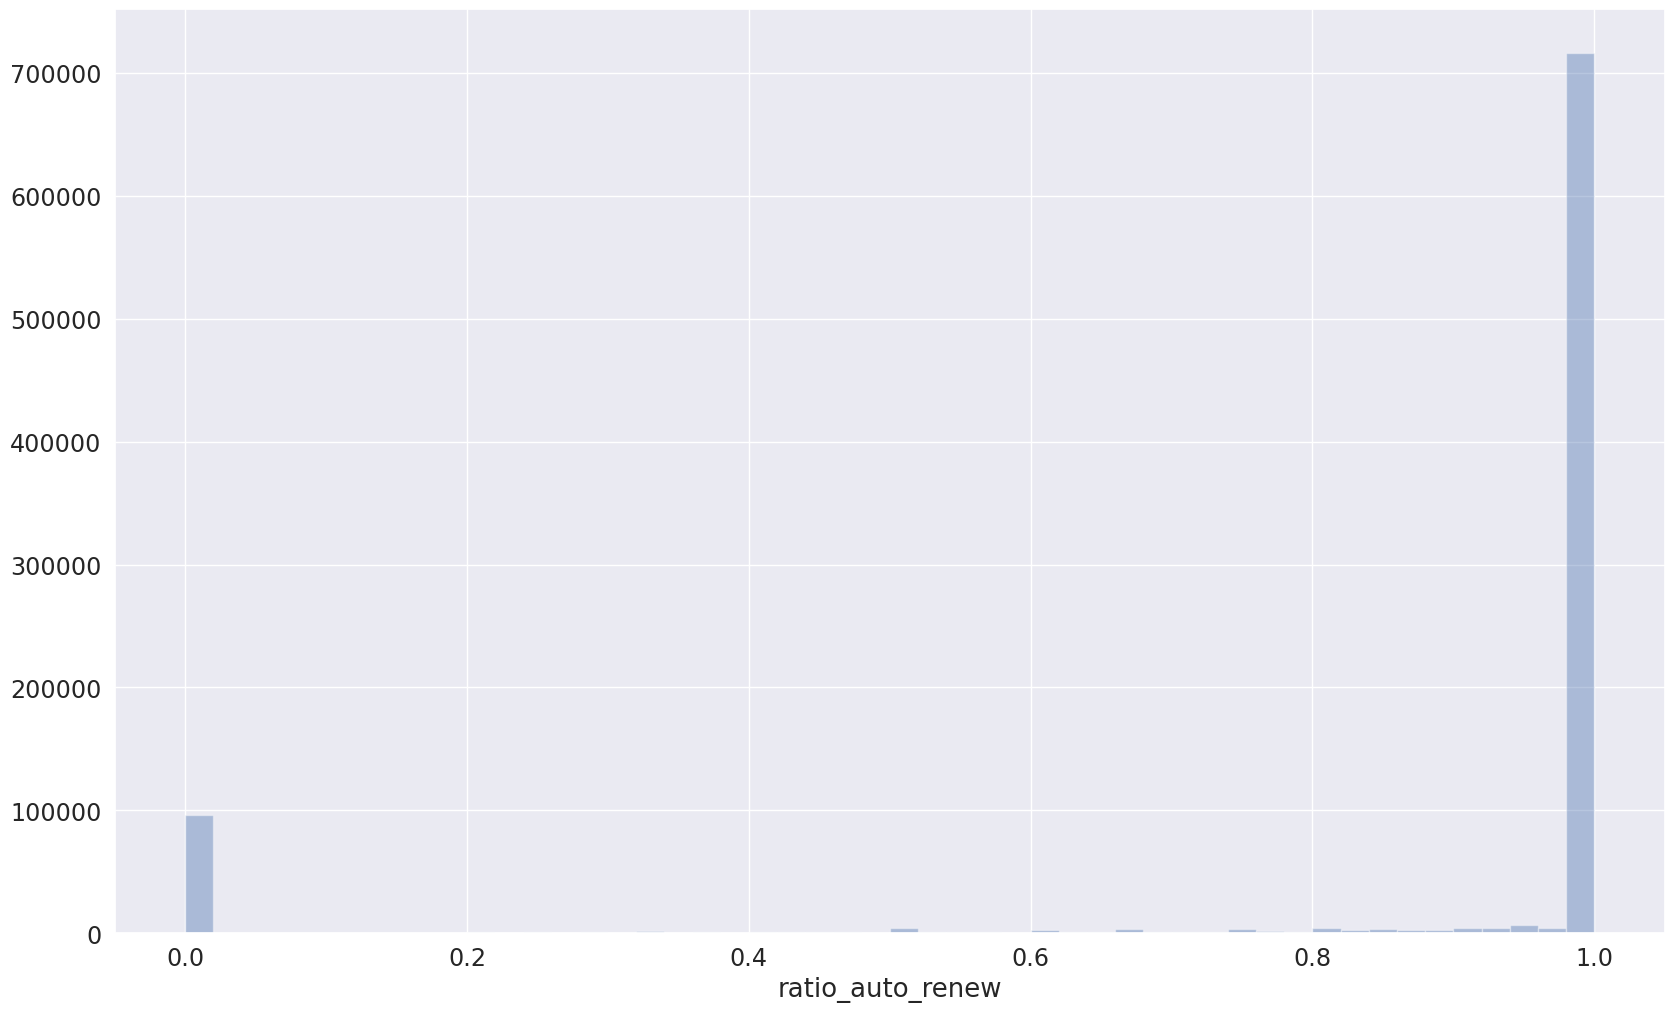

In [95]:
agg_result['ratio_auto_renew'] = agg_result['auto_renew_so_far'] / agg_result['trans_times_so_far']
# show result
fig, ax = plt.subplots(figsize=(20,12))
sns.distplot(agg_result.ratio_auto_renew,kde=False,ax=ax)
ax.set_yscale('squareroot')

In [96]:
print('ratio of All auto_renew:%.3f'%((agg_result.ratio_auto_renew == 1 ).sum() / len(agg_result)))
print('ratio of All manual_renew:%.3f'%((agg_result.ratio_auto_renew == 0 ).sum() / len(agg_result)))
print('ratio of Mix manual&auto renew:%.3f'%(( (agg_result.ratio_auto_renew < 1) & (agg_result.ratio_auto_renew > 0) ).sum() / len(agg_result)))
print('All_auto_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 1').is_churn.mean()) )
print('All_manual_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 0').is_churn.mean()) )

ratio of All auto_renew:0.808
ratio of All manual_renew:0.109
ratio of Mix manual&auto renew:0.084
All_auto_renew churn_rate: 0.013
All_manual_renew churn_rate: 0.287


這裡從圖我們可以發現，多數的使用者都是在兩端，意即目前都自動更新或是目前都手動更新，目前自動更新的使用者佔所有訓練集使用者的80.8%，目前都是手動更新的使用者為10.9%，有調整過的則為8.4%

針對目前皆自動更新的使用者以及目前皆手動更新的使用者計算流失比率，分別為1.3%以及28.7%。這是一個相當有效的分類，並且在這個類別不平均的任務當中，算是樣本數較平均的一項!，比例達到高流失:低流失 ~ 1 : 8

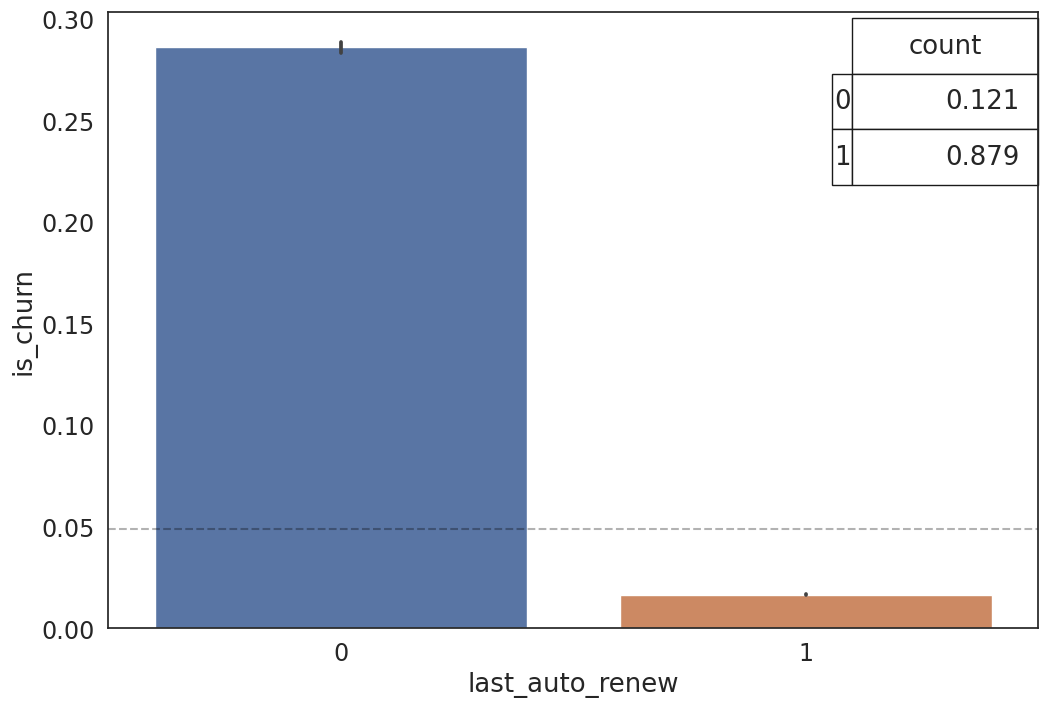

In [54]:
df_train_trans = df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
df_sub_trans = df_sub_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
ft_last_auto_renew_train = df_train_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
ft_last_auto_renew_sub = df_sub_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
# feature rename
ft_last_auto_renew_train.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
ft_last_auto_renew_sub.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
# merge
df_train = pd.merge(df_train,ft_last_auto_renew_train,how='left',on=['msno'])
df_sub = pd.merge(df_sub,ft_last_auto_renew_sub,how='left',on=['msno'])
# plot
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize= (12,8) )
# prepare table (% of each value)
  df_percent = pd.DataFrame( df_train['last_auto_renew'].value_counts().sort_index() / len(df_train) ).round(3) 
# barplot with percent table
  sns.barplot(x='last_auto_renew',y='is_churn',data=df_train,ax=ax)
  ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

可以看到我們的抽樣結果和剛剛的觀察有一些差異 12.1% : 87.9%，這來自於忽略中間自動更新比率在0~1之間，以及隨機抽樣的結果，流失率的部分，我們發現和剛剛的觀察是差不多的，手動更新的使用者平均流失率為28%，自動更新則低於2.5%

### Testing Model: xgb(0.1357)

In [55]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
last_auto_renew_fts = client_level_code_fts + ['last_auto_renew']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew'],
      dtype='object')


In [56]:
print('training using features: \n' ,[fts for fts in last_auto_renew_fts if fts not in exclude_list])
last_auto_renew_model_xgb, last_auto_renew_val_score_xgb,\
last_auto_renew_pred_xgb = model_training_xgb(df_train[last_auto_renew_fts],df_sub[last_auto_renew_fts])
print(last_auto_renew_val_score_xgb)

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn', 'client_level_code', 'last_auto_renew']
[0]	validation_0-logloss:0.22938	validation_1-logloss:0.22913
[70]	validation_0-logloss:0.13531	validation_1-logloss:0.13619
[140]	validation_0-logloss:0.13476	validation_1-logloss:0.13591
[204]	validation_0-logloss:0.13448	validation_1-logloss:0.13588
0.1358716337986695


### One_month_day_listen

In [57]:
# 执行 SQL 查询
query = """
-- one_month_day_listen CTE
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3
                   WHERE date > 20170201 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, features.one_month_day_listen
FROM certain-arcana-418302.KK_data.tuser_label_201703 AS train
LEFT JOIN features 
ON   train.msno = features.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dfom = query_job.to_dataframe()

# 打印结果
dfom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   msno                  886500 non-null  object 
 1   one_month_day_listen  678104 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.5+ MB


In [58]:
# 执行 SQL 查询
query = """
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3
                   WHERE date > 20170301 AND date < 20170331 
                   GROUP BY msno)
SELECT sub.msno, features.one_month_day_listen
FROM certain-arcana-418302.KK_data.tsample_submission_v2 AS sub
LEFT JOIN features 
ON   sub.msno = features.msno 
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dfomt = query_job.to_dataframe()

# 打印结果
dfomt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   msno                  907471 non-null  object 
 1   one_month_day_listen  697354 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.8+ MB


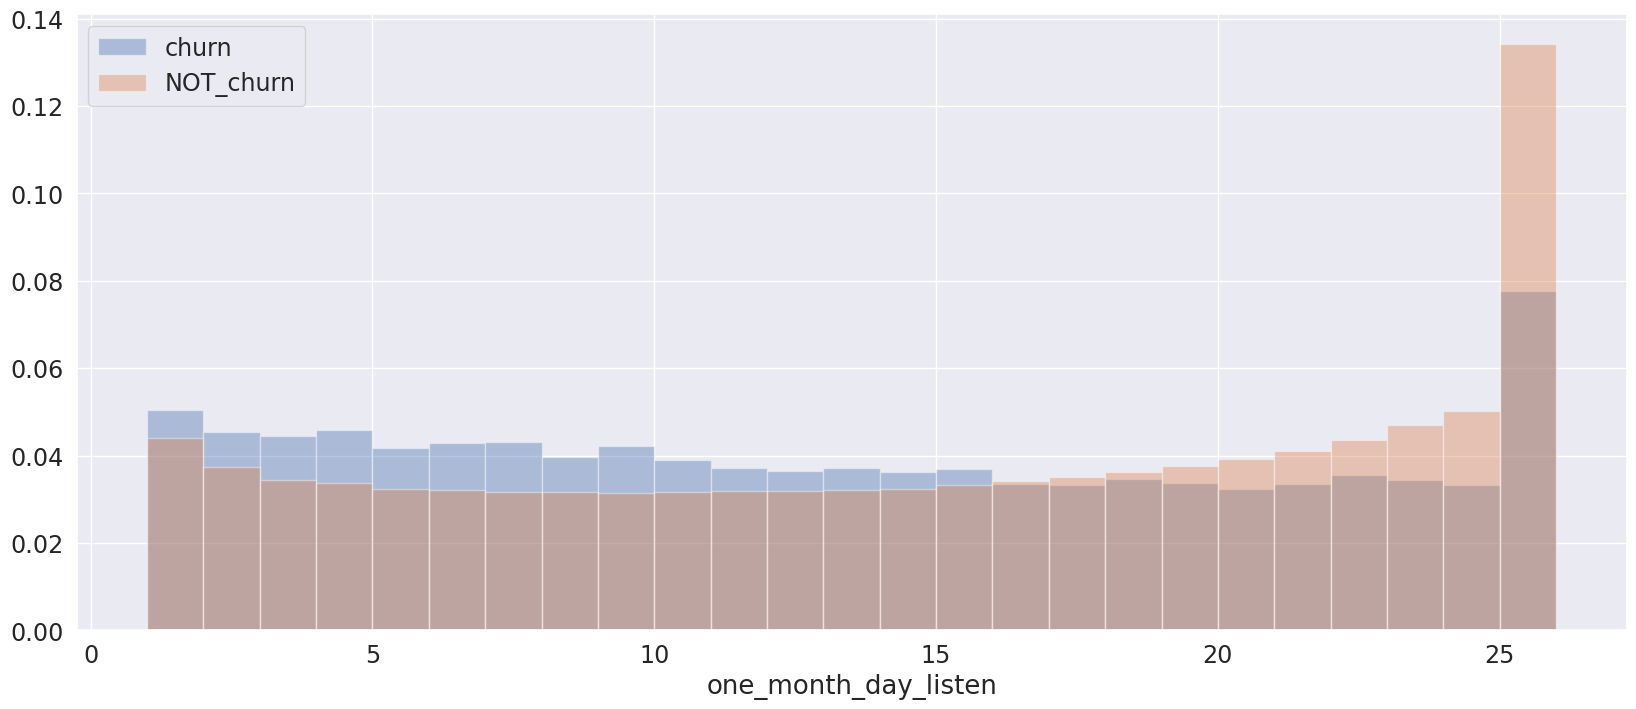

In [59]:
# merge
df_train = pd.merge(df_train, dfom, how='left',on=['msno'])
df_sub = pd.merge(df_sub, dfomt, how='left',on=['msno'])
# plot
df_train['one_month_day_listen'] = df_train['one_month_day_listen'].fillna(-1)
df_sub['one_month_day_listen'] = df_sub['one_month_day_listen'].fillna(-1)
fig, ax = plt.subplots( figsize=(20,8) )
churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 1)
NOT_churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 0)
bins=25
sns.distplot(df_train.loc[churn,'one_month_day_listen'],kde=False,norm_hist=True,label='churn',ax=ax,bins=bins)
sns.distplot(df_train.loc[NOT_churn,'one_month_day_listen'],kde=False,norm_hist=True,label='NOT_churn',ax=ax,bins=bins)
ax.legend()

### Testing Model: xgb(0.1337)

In [60]:
print(df_train.columns)
print(df_sub.columns)
one_month_day_listen_fts = last_auto_renew_fts + ['one_month_day_listen']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew', 'one_month_day_listen'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew', 'one_month_day_listen'],
      dtype='object')


In [ ]:
print('training using features: \n' ,[fts for fts in one_month_day_listen_fts if fts not in exclude_list])
one_month_day_listen_model_xgb, one_month_day_listen_val_score_xgb,\
one_month_day_listen_pred_xgb = model_training_xgb(df_train[one_month_day_listen_fts],df_sub[one_month_day_listen_fts])
print(one_month_day_listen_val_score_xgb)

In [82]:
one_month_day_listen_pred_xgb.to_csv("gs://edward1325811540-bucket1/tsample_submission_v2.csv", index=False)

### Remove_msno

In [81]:
def remove_msno_model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=200,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [73]:
remove_msno_fts = [ 'is_churn',
 'six_month_day_listen',
 'six_month_satis',
 'registered_via',
 'age_under_26',
 'last_last_churn',
 'client_level_code',
 'last_auto_renew',
 'one_month_day_listen']

In [82]:
remove_msno_fts_model_xgb, remove_msno_fts_val_score_xgb,\
remove_msno_fts_pred_xgb = remove_msno_model_training_xgb(df_train[remove_msno_fts],df_sub[one_month_day_listen_fts])
print(remove_msno_fts_val_score_xgb)

[0]	validation_0-logloss:0.22904	validation_1-logloss:0.22874
[70]	validation_0-logloss:0.13325	validation_1-logloss:0.13419
[140]	validation_0-logloss:0.13260	validation_1-logloss:0.13386
[199]	validation_0-logloss:0.13226	validation_1-logloss:0.13379
0.1337815847831527


### BayesSearchCV

In [83]:
X = df_train[remove_msno_fts]
X = X.drop('is_churn', axis = 1)
y = df_train[one_month_day_listen_fts]['is_churn']

In [84]:
X.head()

,six_month_day_listen,six_month_satis,registered_via,age_under_26,last_last_churn,client_level_code,last_auto_renew,one_month_day_listen
0,33.000,0.559,3.000,1,0.000,2,1,14.000
1,46.000,0.361,9.000,1,0.000,4,0,7.000
2,28.000,0.853,9.000,0,0.000,3,1,-1.000
3,71.000,0.707,3.000,-1,0.000,1,0,18.000
4,106.000,0.716,7.000,-1,0.000,2,1,14.000


In [68]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
# 定義超參數搜索空間
param_Bayes = {
    'n_estimators': (10, 400),              # 決策樹的個數
    'max_depth': (1, 100),                   # 樹的最大深度
    'min_samples_split': (2, 10),            # 內部節點再劃分所需的最小樣本數
    'min_samples_leaf': (1, 10),             # 葉子節點最小樣本數
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'auto', 'log2'],
}

# 建立隨機森林分類器
rf = RandomForestClassifier()

# 使用貝葉斯搜索交叉驗證進行超參數調整
Bayes_search = BayesSearchCV(rf, param_Bayes, cv=5, n_iter=20, n_jobs=-1)
Bayes_search.fit(X, y)

model = Bayes_search
parameters = Bayes_search.best_params_

print('Best score: {}'.format(Bayes_search.best_score_))
print('Best parameters: {}'.format(Bayes_search.best_params_))

In [ ]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [ ]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission